In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import os
import pandas as pd
from ast import literal_eval
import sys
import time
from IPython.display import clear_output

#Redirect print output.
f = open('OptFullResults.txt', 'w')
sys.stdout = f

#Method Based On:
#Dimitrakopoulos, P., Jia, W. & Li, C. 
#An Improved Computational Method for the Calculation of Mixture Liquid–Vapor Critical Points. 
#Int J Thermophys 35, 865–889 (2014). https://doi.org/10.1007/s10765-014-1680-7

In [2]:
def LookUpMix(MxN):
    ts = time.time()
    #Read from mixture.csv file to get components.
    path = os.getcwd()
    Mdf = pd.read_csv(path + "/Mixture Compositions.csv", index_col = "Mixture No.")
    mixture = Mdf.iloc[MxN, :]
    mxNames = mixture.index[mixture.notnull()]  
    
    #Assign compositions vlaues for components.
    y = mixture[mixture.notnull()].to_numpy()
    
    
    #Define global variables from mixture props.
    R = 8.31446 #J/(mol*K)
    
    #Obtain component critical values from critical properties list.
    Cdf = pd.read_csv(path + "/Chemical Critical Properties.csv")
    Pc = Cdf.loc[Cdf["Component"].isin(mxNames), "Pc (MPa)"].to_numpy()*10**6 # Pa
    Tc = Cdf.loc[Cdf["Component"].isin(mxNames), "Tc (K)"].to_numpy() #K
    Vc = Cdf.loc[Cdf["Component"].isin(mxNames), "Vc (l/mol)"].to_numpy()*0.001 #m^3
    w = Cdf.loc[Cdf["Component"].isin(mxNames), "w"].to_numpy()
    
    #Define mol vector and number of components.
    n_tot = 1 #mol
    C = len(y)
    
    #Unpack binaqry interaction coefficients
    kdf = pd.read_csv(path + "/Binary Interactions.csv", index_col = "Component")
    k = []
    for i in range(C):
        klist = kdf.loc[mxNames[i], :]
        klist = klist.loc[klist.index.isin(mxNames)]
        k.append(klist.to_numpy())
    k = jnp.array(k)

    EOS = 'SRK'
    print("Components: "+str(mxNames.values)+" At:"+str(y)+" Using "+EOS)
    print("---------------------------------------------")
    return y, Tc, Pc, w, EOS, C, n_tot, R, Vc, k

In [3]:
#nu, a constant dependant on EOS, that affects a.
def nu(EOS):
    if EOS == 'SRK':
        return 0.42748
    if EOS == 'PR':
        return 0.45724

In [4]:
#c, the accentricity polynomial.
def c(i, EOS, w):
    if EOS == 'SRK':
        ci = 0.48
        ci += 1.574*w[i]
        ci += -0.176*w[i]**2
        return ci
    if EOS == 'PR':
        ci = 0.37464
        ci += 1.54226*w[i]
        ci += -0.26992*w[i]**2
        return ci

In [5]:
#ai, the attraction paramater of component i.
def ai(i, T, Tc, Pc, w, R, EOS):
    ai = (R*Tc[i])**2*nu(EOS)/Pc[i]
    ai = ai*(1 + c(i, EOS, w)*(1-(T/Tc[i])**0.5))**2
    return ai

In [6]:
#aij, the binary attraction paramater of component system i-j.
def aijf(T, Tc, Pc, R, w, EOS, C, k):
    aij = jnp.zeros([C, C])
    for i in range(C):
        for j in range(C):
            aij = aij.at[i,j].set((ai(i, T, Tc, Pc, w, R, EOS)*ai(j, T, Tc, Pc, w, R, EOS))**0.5*(1-k[i][j]))
    return aij

In [7]:
#bi, the repulsion paramater of component i.
def b(i, Tc, Pc, R, EOS):
    if EOS == 'SRK':
        bi = 0.08664*R*Tc[i]/Pc[i]
        return bi
    if EOS == 'PR':
        bi = 0.07780*R*Tc[i]/Pc[i]
        return bi

In [8]:
#D1, a parameter that defines the EOS.
def D1(EOS):
    if EOS == 'SRK':
        u0 = 1
        w0 = 0
    if EOS == 'PR':
        u0 = 2
        w0 = -1      
    D1 = (u0 + jnp.sqrt(u0**2-4*w0))/2
    return D1

In [9]:
#D2, a parameter that defines the EOS.
def D2(EOS):
    if EOS == 'SRK':
        u0 = 1
        w0 = 0
    if EOS == 'PR':
        u0 = 2
        w0 = -1      
    D2 = (u0 - jnp.sqrt(u0**2-4*w0))/2
    return D2

In [10]:
#a_tot, the weighted sum of binary attraction interactions.
def a_tot(y, aij, C):
    a_t = 0
    for i in range(C):
        for j in range(C):
            a_t += y[i]*y[j]*aij[i, j]
    return a_t

In [11]:
#b_tot, the weighted sum of repulsion interactions.
def b_tot(y, Tc, Pc, R, EOS, C):
    b_t = 0
    for i in range(C):
        b_t += y[i]*b(i, Tc, Pc, R, EOS)
    return b_t

In [12]:
#alphak, the relative attraction of all interactions with component k.
def alpha(j, y, aij, C):
    alpk = 0
    for i in range(C):
        alpk += y[i]*aij[i,j]
    return alpk/a_tot(y, aij, C)

In [13]:
#betai, the relative repulsion of component k.
def beta(i, y, Tc, Pc, R, EOS, C):
    return b(i, Tc, Pc, R, EOS)/b_tot(y, Tc, Pc, R, EOS, C)

In [14]:
#K, the ratio of critcal volume of mixture to repulsion parameter.
def K(V, Tc, Pc, R, y, EOS, C):
    return V/b_tot(y, Tc, Pc, R, EOS, C)

In [15]:
#F1-F6 are EOS based factors which are f(D1, D2, K)
def F1(Kv, EOS):
    return 1/(Kv-1)

def F2(Kv, EOS):
    F2 = 2/(D1(EOS)-D2(EOS))
    F2 *= (D1(EOS)/(Kv+D1(EOS))-D2(EOS)/(Kv+D2(EOS)))
    return F2

def F3(Kv, EOS):
    F3 = 1/(D1(EOS)-D2(EOS))
    F3 *= ((D1(EOS)/(Kv+D1(EOS)))**2-(D2(EOS)/(Kv+D2(EOS)))**2)
    return F3

def F4(Kv, EOS):
    F4 = 1/(D1(EOS)-D2(EOS))
    F4 *= ((D1(EOS)/(Kv+D1(EOS)))**3-(D2(EOS)/(Kv+D2(EOS)))**3)
    return F4

def F5(Kv, EOS):
    F5 = 2/(D1(EOS)-D2(EOS))
    F5 *= jnp.log((Kv+D1(EOS))/(Kv+D2(EOS)))
    return F5

def F6(Kv, EOS):
    F6 = 2/(D1(EOS)-D2(EOS))
    F6 *= (D1(EOS)/(Kv+D1(EOS))-D2(EOS)/(Kv+D2(EOS)))-jnp.log((Kv+D1(EOS))/(Kv+D2(EOS)))
    return F6

In [16]:
def ChemicalPotential(y, T, V, Tc, Pc, Vc, w, EOS, C, n_tot, R, k):
    Mij = jnp.zeros([C-1, C-1])
    Mrj = jnp.zeros([1, C-1])
    
    #Calculate variable values
    aij = aijf(T, Tc, Pc, R, w, EOS, C, k)
    a_totv = a_tot(y, aij, C)
    b_totv = b_tot(y, Tc, Pc, R, EOS, C)
    
    Kv = K(V, Tc, Pc, R, y, EOS, C)
    
    F1v = F1(Kv, EOS)
    F2v = F2(Kv, EOS)
    F3v = F3(Kv, EOS)
    F4v = F4(Kv, EOS)
    F5v = F5(Kv, EOS)
    F6v = F6(Kv, EOS)
    

    for i in range(C-1):
        for j in range(C-1):
            betaiv = beta(i, y, Tc, Pc, R, EOS, C)
            betajv = beta(j, y, Tc, Pc, R, EOS, C)
            pA = R*T/n_tot**2
            pB = a_totv/(b_totv*n_tot**2)
            A1 = k[i][j]/y[i]
            A2 = F1v*(betaiv+betajv)
            A3 = betaiv*betajv*F1v**2
            B1 = betaiv*betajv*F3v
            B2 = -F5v*aij[i,j]/a_totv
            B3 = F6v*(betaiv*betajv-alpha(i, y, aij, C)*betajv-alpha(j, y, aij, C)*betaiv)
            A = pA*(A1+A2+A3)
            B = pB*(B1+B2+B3)
            Mij = Mij.at[i,j].set(A+B)
    
    r = C-1
    for j in range(C-1):
        betarv = beta(r, y, Tc, Pc, R, EOS, C)
        betajv = beta(j, y, Tc, Pc, R, EOS, C)
        pA = R*T/n_tot**2
        pB = a_totv/(b_totv*n_tot**2)
        A1 = k[r][j]/y[r]
        A2 = F1v*(betarv+betajv)
        A3 = betarv*betajv*F1v**2
        B1 = betarv*betajv*F3v
        B2 = -F5v*aij[r,j]/a_totv
        B3 = F6v*(betarv*betajv-alpha(r, y, aij, C)*betajv-alpha(j, y, aij, C)*betarv)
        A = pA*(A1+A2+A3)
        B = pB*(B1+B2+B3)
        Mrj = Mrj.at[j].set(A+B)
        
    return Mij, Mrj


In [17]:
from functools import partial
@partial(jax.jit, static_argnames=['EOS', 'C', 'n_tot', 'R'])
def GeneralizedCubicHessian(y, T, V, Tc, Pc, Vc, w, EOS, C, n_tot, R, k):
    H = jnp.zeros([C-1, C-1])
    
    Mij, Mrj = ChemicalPotential(y, T, V, Tc, Pc, Vc, w, EOS, C, n_tot, R, k)
    for i in range(C-1):
        for j in range(C-1):
            dM = Mij[i, j]-Mrj[0][j]
            H = H.at[i,j].set(dM)
            
    return H

In [18]:
def VolumeForm(v, P, T, R, y, Tc, Pc, w, EOS, C, k):
    aij = aijf(T, Tc, Pc, R, w, EOS, C, k)
    a = a_tot(y, aij, C)
    b = b_tot(y, Tc, Pc, R, EOS, C)
    d1 = D1(EOS)
    d2 = D2(EOS)
    f = R*T/(v-b)-a/((v+d1*b)*(v+d2*b))-P
    return f

In [19]:
def CostFunction(MxN, T, P):
    [y, Tc, Pc, w, EOS, C, n_tot, R, Vc, k] = LookUpMix(MxN)
    
    
    v = sp.optimize.fsolve(VolumeForm, n_tot*R*T/P, args = (P, T, R, y, Tc, Pc, w, EOS, C, k))
    v = v[0]
    
    H = GeneralizedCubicHessian(y, T, v, Tc, Pc, Vc, w, EOS, C, n_tot, R, k)
    [eig, eigv] = jnp.linalg.eig(H)
    u = jnp.real(eigv[jnp.where(eig == min(eig))])
    u = u/jnp.linalg.norm(u)
    u = u.transpose()
    
    Q1 = jnp.dot(jnp.dot(H, u).transpose(), u)
    dH = jax.jacfwd(GeneralizedCubicHessian)
    dHMat = dH(y, T, v, Tc, Pc, Vc, w, EOS, C, n_tot, R, k)[:,:,:-1]
    Q2 = jnp.dot(dHMat, u)
    Q2 = jnp.dot(Q2.transpose(), u)
    Q2 = jnp.dot(Q2[0].transpose(), u)
    
    return Q1[0][0]**2+Q2[0][0]**2

In [20]:
T = jnp.linspace(300, 600, 25)
P = jnp.linspace(3*10**6, 6*10**6, 25)
Q = jnp.zeros([25, 25])
ts = time.time()
for i in range(25):
    for j in range(25):
        Q = Q.at[i,j].set(CostFunction(4, T[i], P[j]))
        display("T: "+str(T[i])+"; P: "+str(P[j]))
        clear_output(wait = True)
        
tf = time.time()
display("Runtime: "+str(tf-ts))

'Runtime: 290.11974239349365'

In [21]:
X, Y = jnp.meshgrid(T, P)

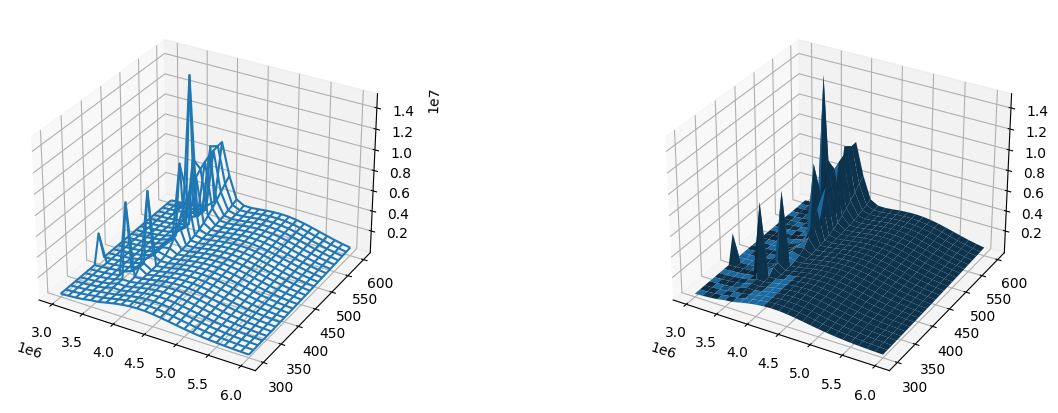

In [24]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize = [15, 5])
ax[1].plot_surface(Y, X, Q)
ax[0].plot_wireframe(Y, X, Q)
